In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

### 1. Transfer to Out-of-Domain Operating Conditions
                            NO Training is Required!!!
* Source Domain: Vin = 200 V, Vo in the range of [160 V, 240 V]
* Exemplary Target Domain:
    * Example 1: Vo = 120 V 
    * Example 2: Vo = 280 V
    * Example 3: Vin = 300 V, Vo = 220 V
    * Example 4: Vin = 300 V, Vo = 380 V

In [3]:
import numpy as np
import torch
from torch import nn
from pann_net import PANN, EulerCell_DAB
from pann_utils import evaluate
import matplotlib.pyplot as plt
%matplotlib inline


# initial estimation of the circuit parameters
n, RL, Lr = 1.0, 120e-3, 63e-6
Ts = 1/50e3
Tslen = 100
dt = Ts/Tslen
dab_Euler_cell = torch.jit.script(EulerCell_DAB(dt, Lr, RL, n)) # define the Euler cell for DAB
pann_dab = torch.jit.script(PANN(dab_Euler_cell)) # define the PANN for DAB

# pann_dab.load_state_dict(torch.load("model_pann.pth")) # load the trained pann
# print(pann_dab.cell.n.item(), pann_dab.cell.RL.item(), pann_dab.cell.Lr.item())

In [4]:
from pann_utils import create_vpvs, get_inputs


##################################################
# Example 1: Vo = 120 V
D0, D1, D2 = 0.08, 0.6, 0.92
Vin, Vref = 200, 120
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
# construct inputs tensor in numpy
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)


##################################################
# Example 2: Vo = 280 V
D0, D1, D2 = 0.2, 0.96, 0.68
Vin, Vref = 200, 280
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp2, vs2 = create_vpvs(D0, D1, D2, Vin, Vref,
                       Tslen, dt, Tsim, Ts,
                       D1_cycle=0.5, D2_cycle=0.5)
inputs2 = np.hstack([vp2[:, None], vs2[:, None]])[None]
# convert to torch FloatTensor
inputs2 = torch.FloatTensor(inputs2)


##################################################
# Example 3: Vin = 300 V, Vo = 220 V
D0, D1, D2 = 0.16, 0.78, 0.88
Vin, Vref = 300, 220
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp3, vs3 = create_vpvs(D0, D1, D2, Vin, Vref,
                       Tslen, dt, Tsim, Ts,
                       D1_cycle=0.5, D2_cycle=0.5)
inputs3 = np.hstack([vp3[:, None], vs3[:, None]])[None]
# convert to torch FloatTensor
inputs3 = torch.FloatTensor(inputs3)


##################################################
# Example 4: Vin = 300 V, Vo = 380 V
D0, D1, D2 = -0.08, 0.98, 0.8
Vin, Vref = 300, 380
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp4, vs4 = create_vpvs(D0, D1, D2, Vin, Vref,
                       Tslen, dt, Tsim, Ts,
                       D1_cycle=0.5, D2_cycle=0.5)
inputs4 = np.hstack([vp4[:, None], vs4[:, None]])[None]
# convert to torch FloatTensor
inputs4 = torch.FloatTensor(inputs4)


In [5]:
##################################################
# Example 1: Vo = 120 V
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_dab(inputs, state0)

    
##################################################
# Example 2: Vo = 280 V
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs2.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states2 = pann_dab(inputs2, state0)
    
    
##################################################
# Example 3: Vin = 300 V, Vo = 220 V
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs3.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states3 = pann_dab(inputs3, state0)
    
    
##################################################
# Example 4: Vin = 300 V, Vo = 380 V
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs4.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states4 = pann_dab(inputs4, state0)
    

<IPython.core.display.Javascript object>


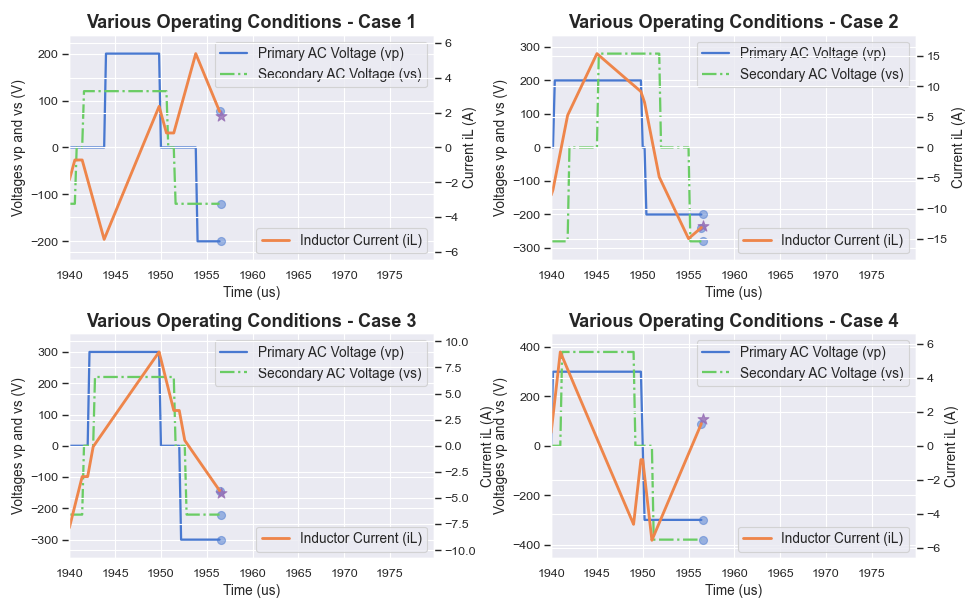

In [6]:
#################################################################################
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget 


if len(inputs.shape)==3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
    inputs2 = inputs2[0, -2*Tslen:]
    states2 = states2[0, -2*Tslen:]
    inputs3 = inputs3[0, -2*Tslen:]
    states3 = states3[0, -2*Tslen:]
    inputs4 = inputs4[0, -2*Tslen:]
    states4 = states4[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7.5))

axs_dualY = []
lines = []
dots = []
for i, (ax, _inputs, _states) in enumerate(zip([ax11, ax12, ax21, ax22],
                                               [inputs, inputs2, inputs3, inputs4],
                                               [states, states2, states3, states4])):
    # Set limits for all plots
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-_inputs.max()*1.2, _inputs.max()*1.2)
    ax_2 = ax.twinx()
    ax_2.set_ylim(-_states.max()*1.2, _states.max()*1.2)
    axs_dualY.append(ax_2)

    # Labels and titles
    ax.set_title(f'Various Operating Conditions - Case {i+1}', fontsize=16, weight='bold')
    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('Voltages vp and vs (V)', fontsize=12)
    ax_2.set_ylabel('Current iL (A)', fontsize=12)

    # Initialize empty lines for both plots
    line_1, = ax.plot([], [], lw=2, label='Primary AC Voltage (vp)', 
                        color=sns.color_palette("muted")[0], linestyle='-')
    line_2, = ax.plot([], [], lw=2, label='Secondary AC Voltage (vs)',
                       color=sns.color_palette("muted")[2], linestyle='-.')
    line_3, = ax_2.plot([], [], lw=2.5, label='Inductor Current (iL)', 
                        color=sns.color_palette("muted")[1], linestyle='-')
    lines.append([line_1, line_2, line_3])
    dot_1 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_2 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_3 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_4 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                         s=100, color=sns.color_palette("muted")[4], marker="*")
    dots.append([dot_1, dot_2, dot_3, dot_4])

    # Add grids and legends
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=12)
    ax_2.legend(loc='lower right', fontsize=12)

    
# Initialize the animation
def init():
    for fig_lines in lines:
        for line in fig_lines:
            line.set_data([], [])
    for fig_dots in dots:
        for dot in fig_dots:
            dot.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot
    return lines, dots

# Update the plots
def update(frame):
    for i, (fig_lines, _inputs, _states) in enumerate(zip(lines, 
                                                          [inputs, inputs2, inputs3, inputs4],
                                                          [states, states2, states3, states4])):
        fig_lines[0].set_data(t[:frame+1], _inputs[:frame+1, 0])  # Update vp plot progressively
        fig_lines[1].set_data(t[:frame+1], _inputs[:frame+1, 1])  # Update vs plot progressively
        fig_lines[2].set_data(t[:frame+1], _states[:frame+1, 0])  # Update iL plot progressively
            
    for i, (fig_dots, _inputs, _states) in enumerate(zip(dots,
                                                         [inputs, inputs2, inputs3, inputs4],
                                                         [states, states2, states3, states4])):
        fig_dots[0].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 0]])
        fig_dots[1].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 1]])
        fig_dots[2].set_offsets(np.c_[t[frame], _states[frame, 0]])
        fig_dots[3].set_offsets(np.c_[t[frame+1], _states[frame+1, 0]])
    return lines, dots


# Create the animation
ani = FuncAnimation(fig, update, frames=len(t)-1, 
                    init_func=init, blit=False, interval=10)

# Save the animation as GIT figure
# ani.save('DAB-Transfer-Operating Conditions.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()

### 2. Transfer to Modulation with More Degree of Freedom (DoF)
                            NO Training is Required!!!
* Source Domain: Triple Phase Shift Modulation
* Exemplary Target Domain: 5-DoF Strategy (Both Phase Shift Angles and Duty Cycles are Adjustable)
    * Example 1: Vin = 200 V, Vo = 140 V, (D0, D1, D2) = (0.1, 0.92, 0.7), (phi1, phi2) = (50%, 35%)  
    * Example 2: Vin = 200 V, Vo = 260 V, (D0, D1, D2) = (0.1, 0.7, 0.92), (phi1, phi2) = (65%, 50%)


In [7]:
##################################################
# Example 1: Vin = 200 V, Vo = 140 V, (D0, D1, D2) = (0.1, 0.92, 0.7), (phi1, phi2) = (50%, 35%) 
D0, D1, D2 = 0.04, 0.84, 0.64
D1_cycle, D2_cycle = 0.5, 0.32
Vin, Vref = 200, 140
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref, Tslen, dt, Tsim, 
                     Ts, D1_cycle=D1_cycle, D2_cycle=D2_cycle)
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)


##################################################
# Example 2: Vin = 200 V, Vo = 260 V, (D0, D1, D2) = (0.1, 0.7, 0.92), (phi1, phi2) = (65%, 50%)
D0, D1, D2 = 0.04, 0.64, 0.84
Vin, Vref = 200, 260
D1_cycle, D2_cycle = 0.68, 0.5
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp2, vs2 = create_vpvs(D0, D1, D2, Vin, Vref,
                       Tslen, dt, Tsim, Ts,
                       D1_cycle=D1_cycle, D2_cycle=D2_cycle)
inputs2 = np.hstack([vp2[:, None], vs2[:, None]])[None]
# convert to torch FloatTensor
inputs2 = torch.FloatTensor(inputs2)

In [8]:
##################################################
# Example 1: Vin = 200 V, Vo = 140 V, (D0, D1, D2) = (0.1, 0.92, 0.7), (phi1, phi2) = (50%, 35%) 
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_dab(inputs, state0)

    
##################################################
# Example 2: Vin = 200 V, Vo = 260 V, (D0, D1, D2) = (0.1, 0.7, 0.92), (phi1, phi2) = (65%, 50%)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs2.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states2 = pann_dab(inputs2, state0)

<IPython.core.display.Javascript object>


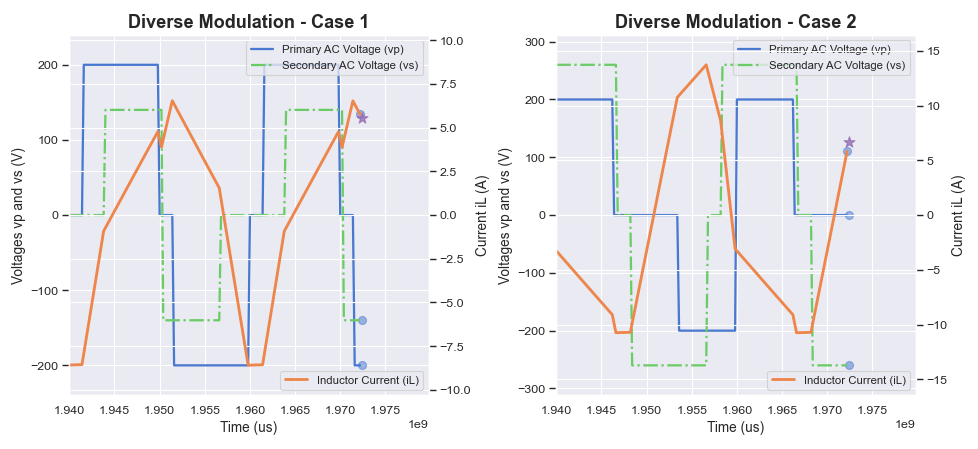

In [9]:
#################################################################################
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget 


if len(inputs.shape)==3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
    inputs2 = inputs2[0, -2*Tslen:]
    states2 = states2[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, (ax11, ax12) = plt.subplots(1, 2, figsize=(12, 5.5))

axs_dualY = []
lines = []
dots = []
for i, (ax, _inputs, _states) in enumerate(zip([ax11, ax12],
                                               [inputs, inputs2],
                                               [states, states2])):
    # Set limits for all plots
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-_inputs.max()*1.2, _inputs.max()*1.2)
    ax_2 = ax.twinx()
    ax_2.set_ylim(-max(_states.max(), abs(_states.min()))*1.2, max(_states.max(), abs(_states.min()))*1.2)
    axs_dualY.append(ax_2)

    # Labels and titles
    ax.set_title(f'Diverse Modulation - Case {i+1}', fontsize=16, weight='bold')
    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('Voltages vp and vs (V)', fontsize=12)
    ax_2.set_ylabel('Current iL (A)', fontsize=12)

    # Initialize empty lines for both plots
    line_1, = ax.plot([], [], lw=2, label='Primary AC Voltage (vp)', 
                        color=sns.color_palette("muted")[0], linestyle='-')
    line_2, = ax.plot([], [], lw=2, label='Secondary AC Voltage (vs)',
                       color=sns.color_palette("muted")[2], linestyle='-.')
    line_3, = ax_2.plot([], [], lw=2.5, label='Inductor Current (iL)', 
                        color=sns.color_palette("muted")[1], linestyle='-')
    lines.append([line_1, line_2, line_3])
    dot_1 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_2 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_3 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_4 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                         s=100, color=sns.color_palette("muted")[4], marker="*")
    dots.append([dot_1, dot_2, dot_3, dot_4])

    # Add grids and legends
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=10)
    ax_2.legend(loc='lower right', fontsize=10)

    
# Initialize the animation
def init():
    for fig_lines in lines:
        for line in fig_lines:
            line.set_data([], [])
    for fig_dots in dots:
        for dot in fig_dots:
            dot.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot
    return lines, dots

# Update the plots
def update(frame):
    for i, (fig_lines, _inputs, _states) in enumerate(zip(lines, 
                                                          [inputs, inputs2],
                                                          [states, states2])):
        fig_lines[0].set_data(t[:frame+1], _inputs[:frame+1, 0])  # Update vp plot progressively
        fig_lines[1].set_data(t[:frame+1], _inputs[:frame+1, 1])  # Update vs plot progressively
        fig_lines[2].set_data(t[:frame+1], _states[:frame+1, 0])  # Update iL plot progressively
            
    for i, (fig_dots, _inputs, _states) in enumerate(zip(dots,
                                                         [inputs, inputs2],
                                                         [states, states2])):
        fig_dots[0].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 0]])
        fig_dots[1].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 1]])
        fig_dots[2].set_offsets(np.c_[t[frame], _states[frame, 0]])
        fig_dots[3].set_offsets(np.c_[t[frame+1], _states[frame+1, 0]])
    return lines, dots


# Create the animation
ani = FuncAnimation(fig, update, frames=len(t)-1, 
                    init_func=init, blit=False, interval=10)

# Save the animation as GIT figure
# ani.save('DAB-Transfer-Modulation Strategy.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()

### 3. Transfer to Different Circuit Parameters
                            NO Training is Required!!!
* Source Domain: Leakage Inductance Lr = 63 uH, RL = 120 mOhm
* Exemplary Target Domain:
    * Example 1: Lr = 6.3 uH, RL = 120 mOhm, n = 1
    * Example 2: RL = 5 Ohm, Lr = 63 uH, n = 1
    * Example 3: n = 2, Lr = 63 uH, RL = 120 mOhm
    * Example 4: n = 2, Lr = 6.3 uH, RL = 3 Ohm    

In [10]:
print(f"""Original circuit parameters are: 
                  Turn ratio - {pann_dab.cell.n.item():.2f}, 
                  Resistance - {pann_dab.cell.RL.item():.4e} Ohm, 
                  Inductance - {pann_dab.cell.Lr.item():.4e} H""")

Original circuit parameters are: 
                  Turn ratio - 1.00, 
                  Resistance - 1.2000e-01 Ohm, 
                  Inductance - 6.3000e-05 H


In [10]:
# Transfer to Different Circuit Parameters through :
# Direct Assignment of Network Neural Parameters (Weights and Biases)

##################################################
# Example 1: Lr = 6.3 uH, RL = 120 mOhm, n = 1; Vin = 200 V, Vo = 160 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([1.0])
pann_dab.cell.RL.data = torch.FloatTensor([120e-3])
pann_dab.cell.Lr.data = torch.FloatTensor([6.3e-6])
print(f"""Circuit parameters of Case-1 are: 
                  Turn ratio - {pann_dab.cell.n.item():.2f}, 
                  Resistance - {pann_dab.cell.RL.item():.4e} Ohm, 
                  Inductance - {pann_dab.cell.Lr.item():.4e} H""")
D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 160
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
# construct inputs tensor in numpy
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_dab(inputs, state0)


##################################################
# Example 2: Lr = 63 uH, RL = 5 Ohm, n = 1; Vin = 200 V, Vo = 160 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([1.0])
pann_dab.cell.RL.data = torch.FloatTensor([5e0])
pann_dab.cell.Lr.data = torch.FloatTensor([63e-6])
print(f"""Circuit parameters of Case-2 are: 
                  Turn ratio - {pann_dab.cell.n.item():.2f}, 
                  Resistance - {pann_dab.cell.RL.item():.4e} Ohm, 
                  Inductance - {pann_dab.cell.Lr.item():.4e} H""")
D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 160
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
# construct inputs tensor in numpy
inputs2 = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs2 = torch.FloatTensor(inputs2)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs2.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states2 = pann_dab(inputs2, state0)

    
##################################################
# Example 3: Lr = 63 uH, RL = 120 mOhm, n = 2; Vin = 200 V, Vo = 80 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([2.0])
pann_dab.cell.RL.data = torch.FloatTensor([120e-3])
pann_dab.cell.Lr.data = torch.FloatTensor([63e-6])
print(f"""Circuit parameters of Case-3 are: 
                  Turn ratio - {pann_dab.cell.n.item():.2f}, 
                  Resistance - {pann_dab.cell.RL.item():.4e} Ohm, 
                  Inductance - {pann_dab.cell.Lr.item():.4e} H""")
D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 80
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
# construct inputs tensor in numpy
inputs3 = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs3 = torch.FloatTensor(inputs3)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs3.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states3 = pann_dab(inputs3, state0)
    
    
##################################################
# Example 4: Lr = 6.3 uH, RL = 3 Ohm, n = 2; Vin = 200 V, Vo = 80 V, (D0, D1, D2) = (0.1, 0.8, 1)
pann_dab.cell.n.data = torch.FloatTensor([2.0])
pann_dab.cell.RL.data = torch.FloatTensor([3e0])
pann_dab.cell.Lr.data = torch.FloatTensor([6.3e-6])
print(f"""Circuit parameters of Case-4 are: 
                  Turn ratio - {pann_dab.cell.n.item():.2f}, 
                  Resistance - {pann_dab.cell.RL.item():.4e} Ohm, 
                  Inductance - {pann_dab.cell.Lr.item():.4e} H""")
D0, D1, D2 = 0.1, 0.8, 1
Vin, Vref = 200, 80
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
# construct inputs tensor in numpy
inputs4 = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs4 = torch.FloatTensor(inputs4)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs4.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states4 = pann_dab(inputs4, state0)

Circuit parameters of Case-1 are: 
                  Turn ratio - 1.00, 
                  Resistance - 1.2000e-01 Ohm, 
                  Inductance - 6.3000e-06 H
Circuit parameters of Case-2 are: 
                  Turn ratio - 1.00, 
                  Resistance - 5.0000e+00 Ohm, 
                  Inductance - 6.3000e-05 H
Circuit parameters of Case-3 are: 
                  Turn ratio - 2.00, 
                  Resistance - 1.2000e-01 Ohm, 
                  Inductance - 6.3000e-05 H
Circuit parameters of Case-4 are: 
                  Turn ratio - 2.00, 
                  Resistance - 3.0000e+00 Ohm, 
                  Inductance - 6.3000e-06 H


<IPython.core.display.Javascript object>


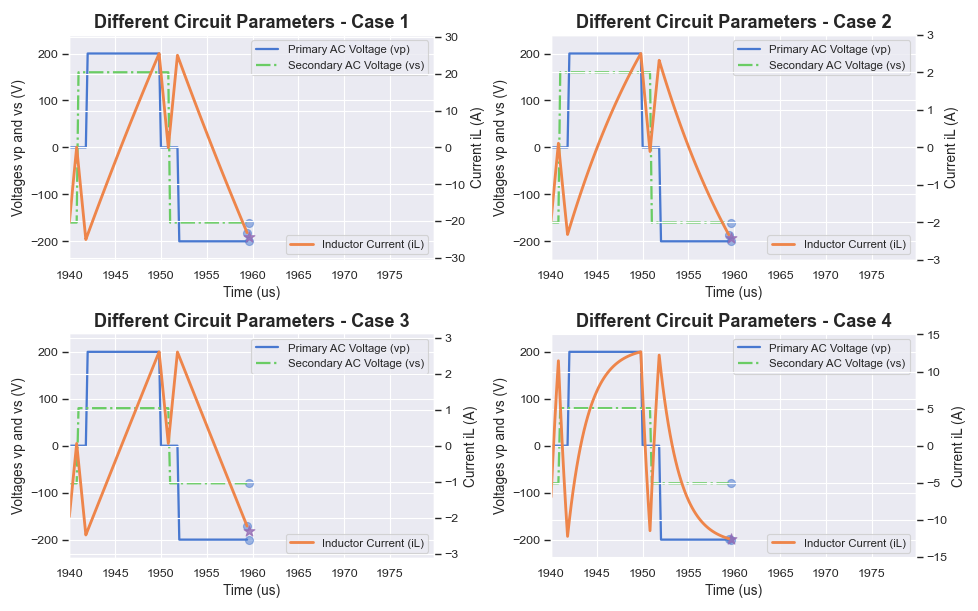

In [11]:
#################################################################################
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget 


if len(inputs.shape)==3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
    inputs2 = inputs2[0, -2*Tslen:]
    states2 = states2[0, -2*Tslen:]
    inputs3 = inputs3[0, -2*Tslen:]
    states3 = states3[0, -2*Tslen:]
    inputs4 = inputs4[0, -2*Tslen:]
    states4 = states4[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize=(12, 7.5))

axs_dualY = []
lines = []
dots = []
for i, (ax, _inputs, _states) in enumerate(zip([ax11, ax12, ax21, ax22],
                                               [inputs, inputs2, inputs3, inputs4],
                                               [states, states2, states3, states4])):
    # Set limits for all plots
    ax.set_xlim(t.min(), t.max())
    ax.set_ylim(-_inputs.max()*1.2, _inputs.max()*1.2)
    ax_2 = ax.twinx()
    ax_2.set_ylim(-_states.max()*1.2, _states.max()*1.2)
    axs_dualY.append(ax_2)

    # Labels and titles
    ax.set_title(f'Different Circuit Parameters - Case {i+1}', fontsize=16, weight='bold')
    ax.set_xlabel('Time (us)', fontsize=12)
    ax.set_ylabel('Voltages vp and vs (V)', fontsize=12)
    ax_2.set_ylabel('Current iL (A)', fontsize=12)

    # Initialize empty lines for both plots
    line_1, = ax.plot([], [], lw=2, label='Primary AC Voltage (vp)', 
                        color=sns.color_palette("muted")[0], linestyle='-')
    line_2, = ax.plot([], [], lw=2, label='Secondary AC Voltage (vs)',
                       color=sns.color_palette("muted")[2], linestyle='-.')
    line_3, = ax_2.plot([], [], lw=2.5, label='Inductor Current (iL)', 
                        color=sns.color_palette("muted")[1], linestyle='-')
    lines.append([line_1, line_2, line_3])
    dot_1 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_2 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_3 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[0], alpha=0.5,
                         s=50, color=sns.color_palette("muted")[0], marker="o")
    dot_4 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                         s=100, color=sns.color_palette("muted")[4], marker="*")
    dots.append([dot_1, dot_2, dot_3, dot_4])

    # Add grids and legends
    ax.grid(True)
    ax.legend(loc='upper right', fontsize=10)
    ax_2.legend(loc='lower right', fontsize=10)

    
# Initialize the animation
def init():
    for fig_lines in lines:
        for line in fig_lines:
            line.set_data([], [])
    for fig_dots in dots:
        for dot in fig_dots:
            dot.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot
    return lines, dots

# Update the plots
def update(frame):
    for i, (fig_lines, _inputs, _states) in enumerate(zip(lines, 
                                                          [inputs, inputs2, inputs3, inputs4],
                                                          [states, states2, states3, states4])):
        fig_lines[0].set_data(t[:frame+1], _inputs[:frame+1, 0])  # Update vp plot progressively
        fig_lines[1].set_data(t[:frame+1], _inputs[:frame+1, 1])  # Update vs plot progressively
        fig_lines[2].set_data(t[:frame+1], _states[:frame+1, 0])  # Update iL plot progressively
            
    for i, (fig_dots, _inputs, _states) in enumerate(zip(dots,
                                                         [inputs, inputs2, inputs3, inputs4],
                                                         [states, states2, states3, states4])):
        fig_dots[0].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 0]])
        fig_dots[1].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 1]])
        fig_dots[2].set_offsets(np.c_[t[frame], _states[frame, 0]])
        fig_dots[3].set_offsets(np.c_[t[frame+1], _states[frame+1, 0]])
    return lines, dots


# Create the animation
ani = FuncAnimation(fig, update, frames=len(t)-1, 
                    init_func=init, blit=False, interval=10)

# Save the animation as GIT figure
# ani.save('DAB-Transfer-Circuit Params.gif', writer='pillow')

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()

### 4. One PANN Model for Diverse Performance Metrics
                            NO Training is Required!!! One Model for All!!!
* PANN Outputs: Waveforms (iL for DAB) over Time
* Diverse Performance Metrics:
    * Conduction/Copper Loss 
    * Peak-to-Peak/RMS Current Stress
    * Zero Voltage Switching / Zero Current Switching
    * Transferred Power 
    * Harmonics
    * Overshoot / Settling Time (Considering the Dynamics)


In [12]:
# initialize pann_dab's circuit parameters
pann_dab.cell.n.data = torch.FloatTensor([1.0])
pann_dab.cell.RL.data = torch.FloatTensor([120e-3])
pann_dab.cell.Lr.data = torch.FloatTensor([63e-6])

# consider an exemplary case
D0, D1, D2 = 0.16, 0.7, 0.95
Vin, Vref = 200, 160
Tsim = 100*Ts # simulation time, considering 100 times of switching periods
# generate voltage waveforms (vp and vs) given one set of modulation parameters
vp, vs = create_vpvs(D0, D1, D2, Vin, Vref,
                     Tslen, dt, Tsim, Ts,
                     D1_cycle=0.5, D2_cycle=0.5)
t = np.arange(0, len(vp)*dt, dt)
inputs = np.hstack([vp[:, None], vs[:, None]])[None]
# convert to torch FloatTensor
inputs = torch.FloatTensor(inputs)
# initialize the state variable
state_dim = 1
state0 = torch.zeros((inputs.shape[0], 1, state_dim)) # it should be 0
# use PANN to infer the state variable iL
pann_dab.eval()
with torch.no_grad():
    # don't capture the computational graph, as this is not training
    states = pann_dab(inputs, state0)

<IPython.core.display.Javascript object>


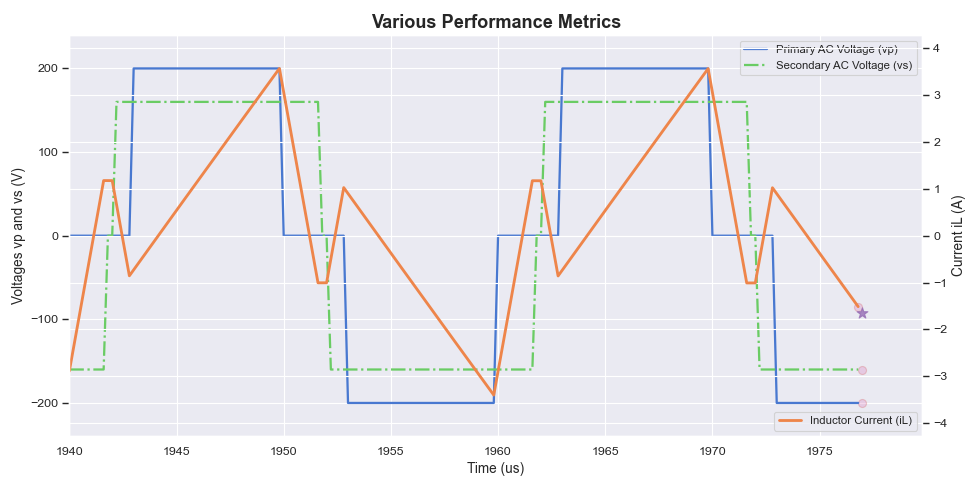

In [13]:
#################################################################################
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook
# if use google colab
# %matplotlib widget 


if len(inputs.shape)==3:
    t = t[-2*Tslen:]*1e6
    inputs = inputs[0, -2*Tslen:]
    states = states[0, -2*Tslen:]
# Example data for vp and vs
# inputs: size (seqlen x inp_dim)
# states: size (seqlen x state_dim)
sns.set(style="darkgrid")  # Use a dark grid background for contrast

t, inputs, states = np.array(t), np.array(inputs), np.array(states)
# Create figure and subplots (two subplots: one for vp, one for vs)
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

axs_dualY = []
lines = []
dots = []
# Set limits for all plots
ax.set_xlim(t.min(), t.max())
ax.set_ylim(-inputs.max()*1.2, inputs.max()*1.2)
ax_2 = ax.twinx()
ax_2.set_ylim(-max(states.max(), abs(states.min()))*1.2, max(states.max(), abs(states.min()))*1.2)
axs_dualY.append(ax_2)

# Labels and titles
ax.set_title(f'Various Performance Metrics', fontsize=16, weight='bold')
ax.set_xlabel('Time (us)', fontsize=12)
ax.set_ylabel('Voltages vp and vs (V)', fontsize=12)
ax_2.set_ylabel('Current iL (A)', fontsize=12)

# Initialize empty lines for both plots
line_1, = ax.plot([], [], lw=2, label='Primary AC Voltage (vp)', 
                    color=sns.color_palette("muted")[0], linestyle='-')
line_2, = ax.plot([], [], lw=2, label='Secondary AC Voltage (vs)',
                   color=sns.color_palette("muted")[2], linestyle='-.')
line_3, = ax_2.plot([], [], lw=2.5, label='Inductor Current (iL)', 
                    color=sns.color_palette("muted")[1], linestyle='-')
lines.append([line_1, line_2, line_3])
dot_1 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[3], alpha=0.3,
                     s=50, color=sns.color_palette("muted")[6], marker="o")
dot_2 = ax.scatter([], [], edgecolor=sns.color_palette("muted")[3], alpha=0.3,
                     s=50, color=sns.color_palette("muted")[6], marker="o")
dot_3 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[3], alpha=0.3,
                     s=50, color=sns.color_palette("muted")[6], marker="o")
dot_4 = ax_2.scatter([], [], edgecolor=sns.color_palette("muted")[4], alpha=0.8,
                     s=100, color=sns.color_palette("muted")[4], marker="*")
dots.append([dot_1, dot_2, dot_3, dot_4])

# Add grids and legends
ax.grid(True)
ax.legend(loc='upper right', fontsize=10)
ax_2.legend(loc='lower right', fontsize=10)


# Initialize the animation
def init():
    for fig_lines in lines:
        for line in fig_lines:
            line.set_data([], [])
    for fig_dots in dots:
        for dot in fig_dots:
            dot.set_offsets(np.empty((0, 2)))  # Initialize empty scatter for subplot
    return lines, dots

# Update the plots
def update(frame):
    for i, (fig_lines, _inputs, _states) in enumerate(zip(lines, 
                                                          [inputs],
                                                          [states])):
        fig_lines[0].set_data(t[:frame+1], _inputs[:frame+1, 0])  # Update vp plot progressively
        fig_lines[1].set_data(t[:frame+1], _inputs[:frame+1, 1])  # Update vs plot progressively
        fig_lines[2].set_data(t[:frame+1], _states[:frame+1, 0])  # Update iL plot progressively
            
    for i, (fig_dots, _inputs, _states) in enumerate(zip(dots,
                                                         [inputs],
                                                         [states])):
        fig_dots[0].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 0]])
        fig_dots[1].set_offsets(np.c_[t[frame+1], _inputs[frame+1, 1]])
        fig_dots[2].set_offsets(np.c_[t[frame], _states[frame, 0]])
        fig_dots[3].set_offsets(np.c_[t[frame+1], _states[frame+1, 0]])
    return lines, dots


# Create the animation
ani = FuncAnimation(fig, update, frames=len(t)-1, 
                    init_func=init, blit=False, interval=10)

# Show the plot
plt.tight_layout()  # Adjust layout for better fit
# Display the animation in Jupyter
plt.show()

In [14]:
from star_metric_adapter import current_stress, locate, soft_switching, power, cu_loss


# Performance Metrics 1: Peak-to-Peak/RMS Current Stress
ipp = current_stress(states[:, 0], metric="ipp")
print(f"ipp for this case study is {ipp:.2f} A.")
print("\n")
# get root-mean-square current stress
irms = current_stress(states[:, 0], metric="irms")
print(f"irms for this case study is {irms:.2f} A.")
print("\n")


# Performance Metrics 2: Copper Loss
copper_loss = cu_loss(states[:, 0], pann_dab.cell.RL.item())
print(f"Copper loss for this case study is: {copper_loss: .3f} W")
print("\n")


# Performance Metrics 3: Transferred Power
active_P = power(inputs[:, 0], inputs[:, 1], states[:, 0], metric="PL")
reactive_Q = power(inputs[:, 0], inputs[:, 1], states[:, 0], metric="Q", n=pann_dab.cell.n.item())
print(f"Active Power is: {active_P:.3f} W, and Reactive Power Q is: {reactive_Q:.3f} Var")
print("\n")


# Performance Metrics 4: Zero Voltage Switching / Zero Current Switching

print("ZVS and ZCS performance of experimental data:")
zvs_perform = soft_switching(states[:, 0], inputs[:, 0], inputs[:, 1], Vin, Vref, threshold=0.)[0]
print(f"Total number of switches that acehive ZVS is: {sum(zvs_perform)}.")
print(f"The ZVS details of s1 to s8 are: {zvs_perform}.")

ipp for this case study is 6.97 A.


irms for this case study is 1.72 A.


Copper loss for this case study is:  0.354 W


Active Power is: 187.617 W, and Reactive Power Q is: 151.481 Var


ZVS and ZCS performance of experimental data:
Total number of switches that acehive ZVS is: 8.0.
The ZVS details of s1 to s8 are: [1. 1. 1. 1. 1. 1. 1. 1.].
